In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers

import matplotlib.pyplot as plt
from IPython.display import HTML
from keras.callbacks import EarlyStopping
import numpy as np
import os

In [2]:
#!pip install numpy==1.22.2 #1.23.5

In [3]:
import tensorflow as tf 
print(tf.__version__)

2.5.0


In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50 #50

We will use image_dataset_from_directory api to load all images in tensorflow dataset

In [5]:
dataset=tf.keras.preprocessing.image_dataset_from_directory("plant",seed=123,shuffle=True,image_size=(IMAGE_SIZE,IMAGE_SIZE),batch_size=BATCH_SIZE)

Found 2152 files belonging to 5 classes.


In [6]:
classnames=dataset.class_names

In [7]:
classnames

['Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'api',
 'models']

#### each batch has 32 images, and each image has 3 channels

In [8]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())#labels for each image in the patch

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


### Visualizing images

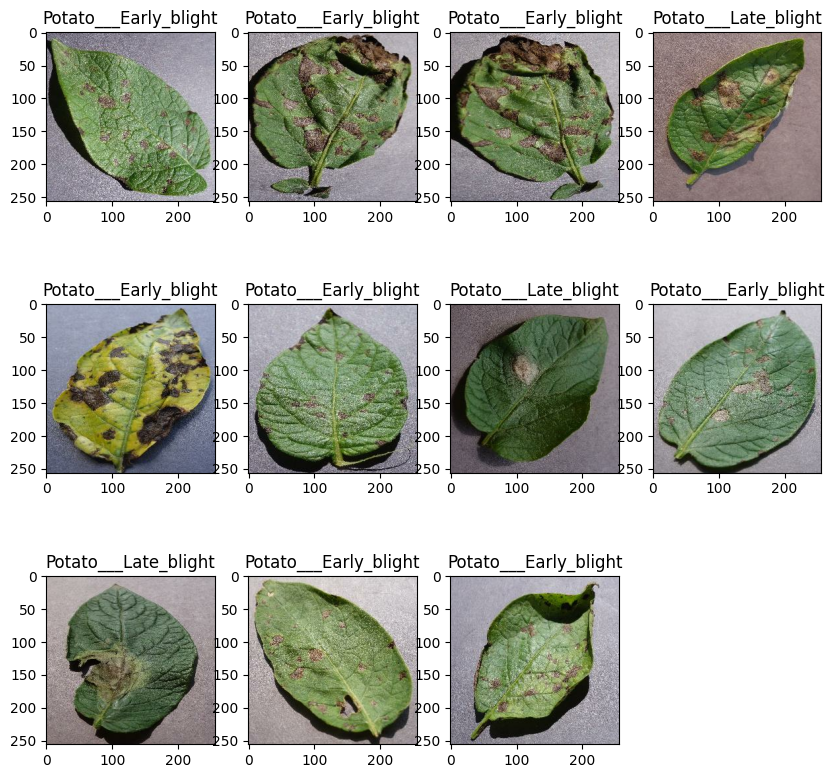

In [9]:
plt.figure(figsize=(10, 10))
for image_batch,label_batch in dataset.take(1):
    for i in range(11):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(classnames[label_batch[i]])

## split dataset into train and test datasets: %80 training, %10 validation, %10 testing

In [10]:
len(dataset) #there are 68 batches

68

In [11]:
train_size= 0.8*len(dataset)
train_size

54.400000000000006

In [12]:
train_dataset=dataset.take(int(train_size))

In [13]:
test_dataset = dataset.skip(int(train_size)) #skips the first 54 images that are in training set
len(test_dataset)

14

#### now we want to take half of the test dataset as validation set

In [14]:
validation_size= 0.5 *len(test_dataset)
validation_dataset=test_dataset.take(int(validation_size))

In [15]:
len(validation_dataset)

7

In [16]:
def get_dataset_partition(dataset,train_split=0.8,validation_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    assert(train_split+validation_split+test_split)==1
    dataset_size=len(dataset)
    if shuffle:
        dataset=dataset.shuffle(shuffle_size,seed=12)
        
    train_size=int(train_split*dataset_size)
    validation_size=int(validation_split*dataset_size)
    train_dataset=dataset.take(train_size)
    validation_dataset=dataset.skip(train_size).take(validation_size)
    test_dataset=dataset.skip(train_size).skip(validation_size)
    return train_dataset,validation_dataset,test_dataset

In [17]:
train_dataset,validation_dataset,test_dataset=get_dataset_partition(dataset)

In [18]:
print(len(train_dataset))
print(len(validation_dataset))
print(len(test_dataset))

54
6
8


# Data Augmentation:

In [19]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Applying data augmentation to training dataset

In [21]:
train_dataset=train_dataset.map(lambda x,y:(data_augmentation(x,training=True),y)
                               ).prefetch(buffer_size=tf.data.AUTOTUNE)

#### to normalize the values of pixels between 0 and255

In [22]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Building the Model

In [23]:
from tensorflow.keras.models import Sequential

In [24]:
n_classes=3

In [25]:
#from keras.models import Sequential


model=Sequential([
    resize_and_rescale,
    layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])

In [26]:
model.build(input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS))

In [27]:
es = EarlyStopping(monitor='val_loss', mode="auto",verbose=1, patience=7)

In [28]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 30, 30, 64)         

In [30]:
history=model.fit(train_dataset,batch_size=BATCH_SIZE, validation_data=validation_dataset,verbose=1,epochs=EPOCHS,callbacks=[es])

Epoch 1/50
54/54 [==============================] - 14s 121ms/step - loss: 0.9118 - accuracy: 0.4566 - val_loss: 0.8312 - val_accuracy: 0.4792
Epoch 2/50
54/54 [==============================] - 6s 88ms/step - loss: 0.8114 - accuracy: 0.6056 - val_loss: 0.5703 - val_accuracy: 0.7440
Epoch 3/50
54/54 [==============================] - 6s 87ms/step - loss: 0.5072 - accuracy: 0.7703 - val_loss: 0.4103 - val_accuracy: 0.8281
Epoch 4/50
54/54 [==============================] - 6s 86ms/step - loss: 0.3481 - accuracy: 0.8568 - val_loss: 0.4127 - val_accuracy: 0.8438
Epoch 5/50
54/54 [==============================] - 6s 86ms/step - loss: 0.2732 - accuracy: 0.8920 - val_loss: 0.2825 - val_accuracy: 0.9062
Epoch 6/50
54/54 [==============================] - 7s 97ms/step - loss: 0.2252 - accuracy: 0.9038 - val_loss: 0.1777 - val_accuracy: 0.9167
Epoch 7/50
54/54 [==============================] - 6s 88ms/step - loss: 0.2151 - accuracy: 0.9167 - val_loss: 0.1265 - val_accuracy: 0.9375
Epoch 8/50


In [31]:
scores=model.evaluate(test_dataset)

8/8 [==============================] - 2s 21ms/step - loss: 0.0048 - accuracy: 1.0000


In [32]:
len(history.history['loss'])

33

### Ploting accuracy and loss for Training and validation sets

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

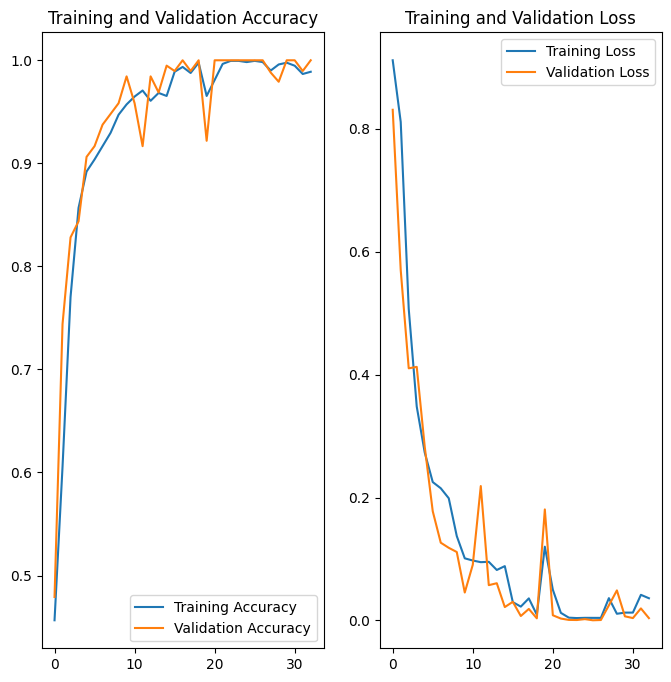

In [34]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(len(history.history['loss'])), acc, label='Training Accuracy')
plt.plot(range(len(history.history['loss'])), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(history.history['loss'])), loss, label='Training Loss')
plt.plot(range(len(history.history['loss'])), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### predicting using one of the Images

actual label: Potato___Early_blight
predicted label: Potato___Early_blight


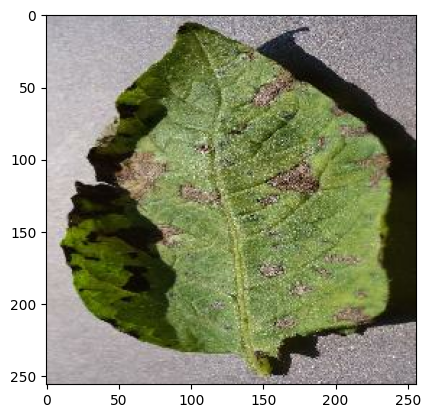

In [35]:
for images,labels in test_dataset.take(1):
    one_image=images[0].numpy().astype('uint8')
    one_label=labels[0].numpy()
    plt.imshow(one_image)
    print("actual label:",classnames[one_label])
    predict=model.predict(images)
    predic_label=classnames[(np.argmax(predict[0]))]
    print("predicted label:",predic_label)

# Prediction Function:

In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = classnames[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

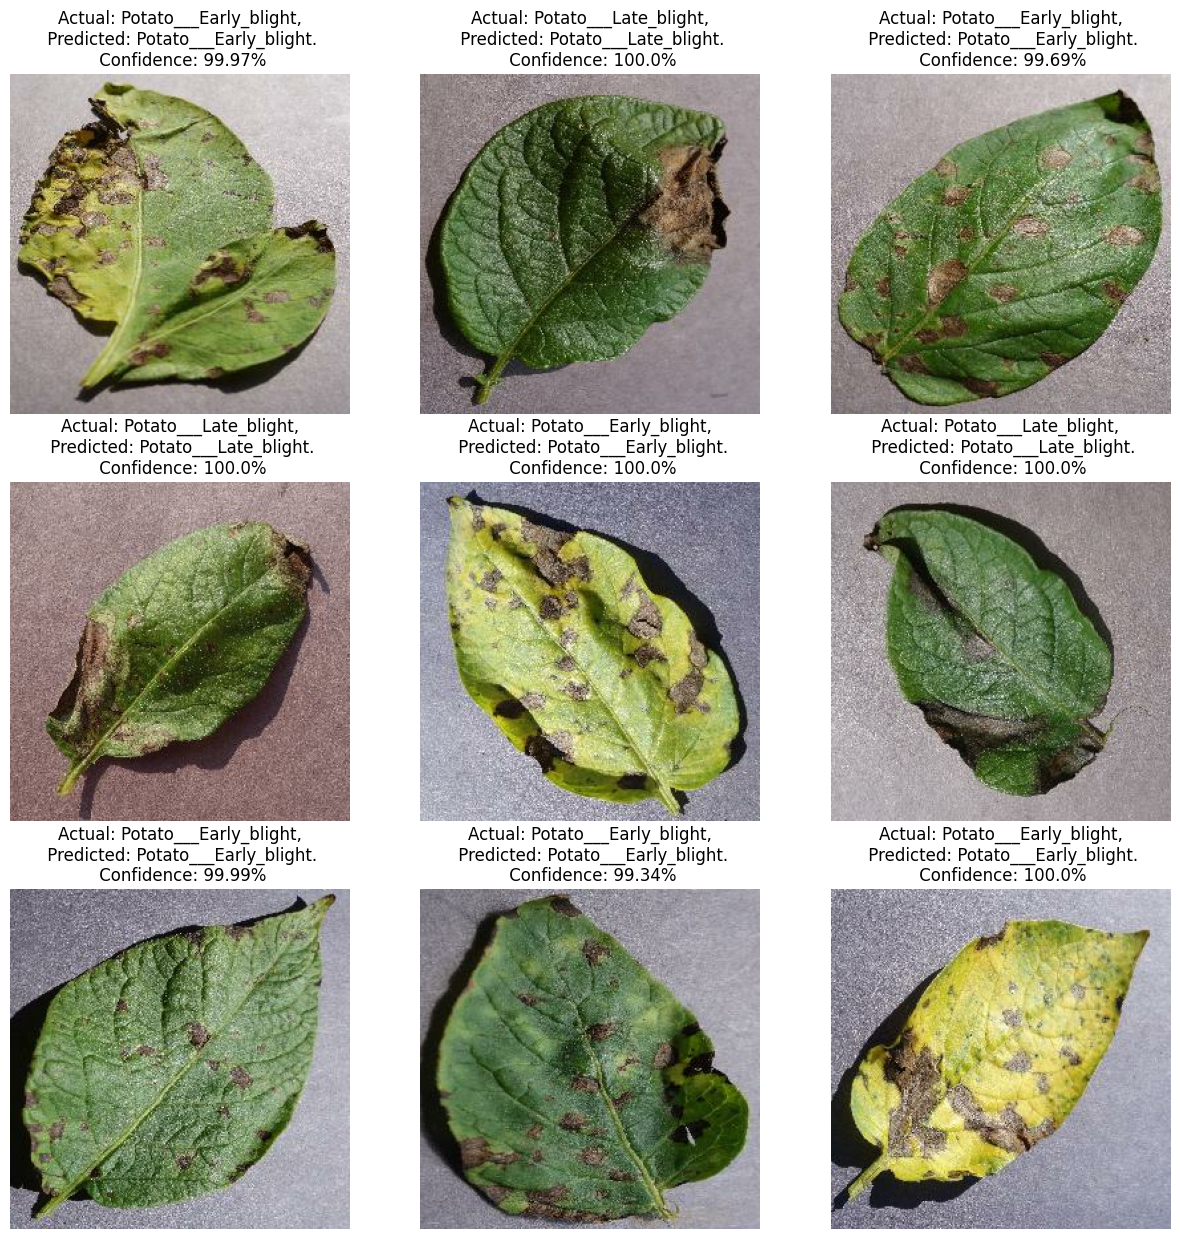

In [37]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = classnames[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# Saving the Model

In [38]:
# model_version=max([int(i) for i in os.listdir("plant/models") + [0]])+1
# model.save(f"plant/models/{model_version}")

In [39]:
# model.save("potatoes.h5")

In [40]:
#from tensorflow.keras.layers import Dense 
import tempfile
_, baseline_model_accuracy = model.evaluate(
    test_dataset, verbose=1)

print('Baseline test accuracy:', baseline_model_accuracy)

_, keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)


8/8 [==============================] - 2s 37ms/step - loss: 0.0034 - accuracy: 1.0000
Baseline test accuracy: 1.0
Saved baseline model to: C:\Users\hamoudi\AppData\Local\Temp\tmpgv6jnomy.h5


# installing requirement for api

In [41]:
import tensorflow as tf 
print(tf.__version__)

2.5.0


In [42]:
#!pip install tensorflow-serving-api==2.10.0

In [43]:
#!pip install fastapi

In [44]:
#!pip install python-multipart

In [45]:
#!pip install uvicorn

# Model Pruning

In [46]:
import numpy as np 
import pandas as pd
import os
import random
import glob
import cv2
import time
import tensorflow as tf
import matplotlib.pyplot as plt
#import seaborn as sns
from PIL import Image
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

C:\Users\hamoudi\anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.5.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [47]:
#!pip install seaborn

In [48]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical ,Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation, Dropout, UpSampling2D
from tensorflow.keras.optimizers import Adadelta, Nadam ,Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, TensorBoard
# from tensorflow.lite. import from_keras_model
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import tensorflow_model_optimization as tfmot
import os
# print(os.listdir("../models"))
from glob import glob
from pathlib import Path
import shutil
from tqdm import tqdm_notebook
from random import sample, choice
import tensorflow as tf
import tempfile
# Any results you write to the current directory are saved as output.
import time

In [49]:
main_input = Input(shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS), name = 'img_input')
c1 =layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS))(main_input)
p1 =layers.MaxPooling2D((2,2))(c1)
c1=layers.Conv2D(64,kernel_size=(3,3),activation='relu')(p1)
p1=layers.MaxPooling2D((2,2))(c1)
c1=layers.Conv2D(64,kernel_size=(3,3),activation='relu')(p1)
p2=layers.MaxPooling2D((2,2))(c1)
c2=layers.Conv2D(64,kernel_size=(3,3),activation='relu')(p2)
p2=layers.MaxPooling2D((2,2))(c2)
c2=layers.Conv2D(64,kernel_size=(3,3),activation='relu')(p2)
p2=layers.MaxPooling2D((2,2))(c2)
c2=layers.Conv2D(64,kernel_size=(3,3),activation='relu')(p2)
p3=layers.MaxPooling2D((2,2))(c2)
f3=layers.Flatten()(p3)
d4=layers.Dense(64,activation='relu')(f3)
d5=layers.Dense(n_classes,activation='softmax')(d4)
model1 = Model(inputs = [main_input], outputs = [d5])

In [50]:
def tflite_make_prediction(tflite_file_name, img_file, data_type):
    interpreter = tf.lite.Interpreter(model_path=tflite_file_name)
    interpreter.allocate_tensors()
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    test_image = load_img(img_file, target_size=(256,256,1), color_mode='grayscale') #target_size=(224,224,1)
    test_image = img_to_array(test_image)
    if data_type == "float32":
        test_image = (test_image /255.)
    test_image = np.expand_dims(test_image, axis=0).astype(data_type)
    interpreter.set_tensor(input_index, test_image)
    
    start_time = time.time()
    interpreter.invoke()
    stop_time = time.time()
    print('time: {:.3f}ms'.format(stop_time - start_time))
    
    output = interpreter.tensor(output_index)
    prediction = np.array(output()[0])
    return prediction

### Train and evaluate the model against baseline

In [52]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
#batch_size = 2
#epochs = 10
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = len(train_dataset) * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.25,
                                                               final_sparsity=0.55,
                                                               begin_step=0,
                                                               end_step=end_step)
}


model_for_pruning = prune_low_magnitude(model1, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_input (InputLayer)       [(None, 256, 256, 3)]     0         
_________________________________________________________________
prune_low_magnitude_conv2d_6 (None, 254, 254, 32)      1762      
_________________________________________________________________
prune_low_magnitude_max_pool (None, 127, 127, 32)      1         
_________________________________________________________________
prune_low_magnitude_conv2d_7 (None, 125, 125, 64)      36930     
_________________________________________________________________
prune_low_magnitude_max_pool (None, 62, 62, 64)        1         
_________________________________________________________________
prune_low_magnitude_conv2d_8 (None, 60, 60, 64)        73794     
_________________________________________________________________
prune_low_magnitude_max_pool (None, 30, 30, 64)        1     

In [53]:
import tempfile


In [55]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(train_dataset,
                  epochs=10, validation_data=validation_dataset,
                  callbacks=callbacks)

Epoch 1/10
54/54 [==============================] - 10s 155ms/step - loss: 3.3498e-04 - accuracy: 1.0000 - val_loss: 6.2731e-04 - val_accuracy: 1.0000
Epoch 2/10
54/54 [==============================] - 8s 111ms/step - loss: 3.3683e-04 - accuracy: 1.0000 - val_loss: 1.9600e-04 - val_accuracy: 1.0000
Epoch 3/10
54/54 [==============================] - 8s 112ms/step - loss: 2.7616e-04 - accuracy: 1.0000 - val_loss: 2.1959e-04 - val_accuracy: 1.0000
Epoch 4/10
54/54 [==============================] - 8s 111ms/step - loss: 2.4667e-04 - accuracy: 1.0000 - val_loss: 1.8259e-04 - val_accuracy: 1.0000
Epoch 5/10
54/54 [==============================] - 8s 111ms/step - loss: 2.2105e-04 - accuracy: 1.0000 - val_loss: 1.3418e-04 - val_accuracy: 1.0000
Epoch 6/10
54/54 [==============================] - 7s 105ms/step - loss: 1.9356e-04 - accuracy: 1.0000 - val_loss: 1.1321e-04 - val_accuracy: 1.0000
Epoch 7/10
54/54 [==============================] - 7s 105ms/step - loss: 1.6764e-04 - accuracy: 1.

### Create 3x smaller models from pruning
Both tfmot.sparsity.keras.strip_pruning and applying a standard compression algorithm (e.g. via gzip) are necessary to see the compression benefits of pruning.

In [56]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

_, pruned_keras_file = tempfile.mkstemp('potatostrippedandprunedmodel.h5')
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)


Saved pruned Keras model to: C:\Users\hamoudi\AppData\Local\Temp\tmp3_pg41ytpotatostrippedandprunedmodel.h5


#### Then, create a compressible model for TFLite.

In [57]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()

_, pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(pruned_tflite_file, 'wb') as f:
  f.write(pruned_tflite_model)

print('Saved pruned TFLite model to:', pruned_tflite_file)


INFO:tensorflow:Assets written to: C:\Users\hamoudi\AppData\Local\Temp\tmpn_6jox62\assets
Saved pruned TFLite model to: C:\Users\hamoudi\AppData\Local\Temp\tmphccchmtl.tflite


### Define a helper function to actually compress the models via gzip and measure the zipped size.

In [58]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)


In [59]:
print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))

print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(pruned_keras_file)))
print("Size of gzipped pruned TFlite model: %.2f bytes" % (get_gzipped_model_size(pruned_tflite_file)))

Size of gzipped baseline Keras model: 684596.00 bytes
Size of gzipped pruned Keras model: 390084.00 bytes
Size of gzipped pruned TFlite model: 385449.00 bytes


# Quantization:

In [60]:
converter = tf.lite.TFLiteConverter.from_keras_model(model1)

# Enable post-training quantization
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]

# Convert the model
tflite_model = converter.convert()

# Save the model
with open('potato_model_quantized.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\hamoudi\AppData\Local\Temp\tmpxs50oc66\assets


INFO:tensorflow:Assets written to: C:\Users\hamoudi\AppData\Local\Temp\tmpxs50oc66\assets


### Quantization-Aware Training

In [61]:
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model1)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [62]:
q_aware_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_input (InputLayer)       [(None, 256, 256, 3)]     0         
_________________________________________________________________
quantize_layer (QuantizeLaye (None, 256, 256, 3)       3         
_________________________________________________________________
quant_conv2d_6 (QuantizeWrap (None, 254, 254, 32)      963       
_________________________________________________________________
quant_max_pooling2d_6 (Quant (None, 127, 127, 32)      1         
_________________________________________________________________
quant_conv2d_7 (QuantizeWrap (None, 125, 125, 64)      18627     
_________________________________________________________________
quant_max_pooling2d_7 (Quant (None, 62, 62, 64)        1         
_________________________________________________________________
quant_conv2d_8 (QuantizeWrap (None, 60, 60, 64)        37059 

In [63]:
q_aware_model.fit(train_dataset,
                  epochs=EPOCHS, validation_data=validation_dataset,
                  callbacks=callbacks)

Epoch 1/50


C:\Users\hamoudi\anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:4929: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


 6/54 [==>...........................] - ETA: 30s - loss: 0.5037 - accuracy: 0.7656WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0821s vs `on_train_batch_end` time: 0.4689s). Check your callbacks.


54/54 [==============================] - 22s 227ms/step - loss: 0.2358 - accuracy: 0.8973 - val_loss: 0.1028 - val_accuracy: 0.9531
Epoch 2/50
54/54 [==============================] - 9s 144ms/step - loss: 0.1190 - accuracy: 0.9583 - val_loss: 0.0778 - val_accuracy: 0.9896
Epoch 3/50
54/54 [==============================] - 9s 139ms/step - loss: 0.1051 - accuracy: 0.9595 - val_loss: 0.1113 - val_accuracy: 0.9427
Epoch 4/50
54/54 [==============================] - 9s 142ms/step - loss: 0.0911 - accuracy: 0.9670 - val_loss: 0.1165 - val_accuracy: 0.9375
Epoch 5/50
54/54 [==============================] - 9s 144ms/step - loss: 0.0597 - accuracy: 0.9783 - val_loss: 0.1431 - val_accuracy: 0.9479
Epoch 6/50
54/54 [==============================] - 9s 137ms/step - loss: 0.0779 - accuracy: 0.9707 - val_loss: 0.0753 - val_accuracy: 0.9635
Epoch 7/50
54/54 [==============================] - 9s 139ms/step - loss: 0.0431 - accuracy: 0.9877 - val_loss: 0.0274 - val_accuracy: 0.9896
Epoch 8/50
54/54

In [ ]:
# # Save the quantized model
# model.save('quantized_model.h5')